# Projeto 1

Fonte dedados: https://rapidapi.com/mrngstar/api/instagram-scraper-api3

Instagram: marcitocastro (482001976) - https://www.instagram.com/marcitocastro/

- [x] fotografia do perfil dia a dia (1 request por dia)
- [x] informações gerais sobre as ultimas 24 postagens (2 requests por dia)
- [x] informações da ultima postagem (comentarios, Gerais do post) (17 requests por dia)

## Instalando dependencias

In [5]:
!pip install requests

In [6]:
!apt-get update # Update apt-get repository.
!apt-get install openjdk-8-jdk-headless -qq > /dev/null # Install Java.
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz # Download Apache Sparks.
!tar xf spark-3.1.1-bin-hadoop3.2.tgz # Unzip the tgz file.
!pip install -q findspark # Install findspark. Adds PySpark to the System path during runtime.
!ls

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Ign:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,267 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,150 kB]
Get:14 http

In [7]:
!pip install pyspark==3.1.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.3/212.3 MB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 14.3 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767580 sha256=23f2f83c225ac0bb1ecb48f3eed8d23148f0f61bb7acee94e95c69766471c137
  Stored in directory: /root/.cache/pip/wheels/a0/3f/72/8efd988f9ae041f051c75e6834cd92dd6d13a726e206e8b6f3
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [627]:
!pip install groq

## Importando dependencias

In [629]:
import requests
import json
import os
from google.colab import userdata
import sys
from typing import List
from array import ArrayType
from datetime import datetime
import time

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import findspark
import pyspark
from pyspark.sql import DataFrame, SparkSession
import pyspark.sql.types as T
import pyspark.sql.functions as F
from pyspark.sql.types import StructType,StructField, StringType
from pyspark.sql.functions import from_unixtime, col, date_format

from groq import Groq


## Configurando parâmetros de API e inicializando o Spark

### Configurando Parâmetros da API

In [630]:
url = userdata.get('api_url')

data_lake_path = '/content/Datalake/Instagram/'
profile_path = 'Perfil_v2/'
posts_path = 'Postagens_v2/'
comments_path = 'comentarios/'
classified_comments_path = 'comentarios_classificacao/'

influencer = "marcitocastro"

headers = {
	"x-rapidapi-key": userdata.get('x-rapidapi-key'),
	"x-rapidapi-host": "instagram-scraper-api3.p.rapidapi.com"
}

codigo_ultima_postagem = ''

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"



### Inicializando o Spark

In [631]:
findspark.init()
findspark.find()

# Create a PySpark session
spark = SparkSession \
       .builder \
       .appName("Our First Spark Example") \
       .getOrCreate()
       #  .appName("Monitoramento de Perfil Instagram")\
spark

## Coletando informações do Instagram

### Coletando PERFIL


Após inicializarmos as ferramentas e parâmetros de API vamos coletar as informações do perfil.
\
Primeiro vamos enviar a requisição para nossa API na rota *`user_info`* que devolverá as principais informações do nosso influenciador através da função `get_profile`.

Após isso extraímos as informações dos campos com o método `extract_profile_data`.
\
Por fim salvamos as informações extraídas em um DataFrame Spark com o método `save_profile_data`.

In [632]:
def get_profile(influencer):
    """
    Obtém o perfil de um influenciador a partir de uma API.

    Esta função faz uma requisição GET para obter as informações de perfil
    de um influenciador com base em seu nome de usuário ou ID. O resultado
    da requisição é retornado em formato JSON.

    Args:
        influencer (str): Nome de usuário ou ID do influenciador cuja informação de perfil
                          será recuperada.

    Returns:
        dict: Um dicionário contendo os dados do perfil do influenciador retornados pela API,
              no formato JSON.

    Raises:
        requests.exceptions.RequestException: Se a requisição HTTP falhar por algum motivo,
                                              como problemas de rede ou erro de autenticação.
    """
    querystring = {"username_or_id": influencer}

    method = 'user_info'
    response = requests.get(f'{url}{method}',
                              headers=headers,
                              params=querystring)

    response_instagram = response.json()
    return response_instagram

def extract_profile_data(response_instagram_profile_data):
    """
    Salva os dados de perfil do influenciador em um DataFrame Spark.

    Args:
        response_instagram_profile_data (dict): Dados das postagens em formato JSON.

    Returns:
        extracted_profile_data: Dados extraídos em formato de dicionário.

    Campos extraídos:
        - full_name, id, biography, category, bio_links, follower_count,
          following_count, hd_profile_pic_versions_url, media_count, is_verified,
          threads_profile_glyph_url
    """
    perfil = response_instagram_profile_data.get("data")

    full_name = perfil.get('full_name')
    id = perfil.get('id')
    biography = perfil.get('biography')
    category = perfil.get('category')
    bio_links = perfil.get('bio_links')
    follower_count = perfil.get('follower_count')
    following_count = perfil.get('following_count')
    hd_profile_pic_versions_url = perfil.get('hd_profile_pic_versions')[0].get('url')

    media_count = perfil.get('media_count')
    is_verified = perfil.get('is_verified')
    threads_profile_glyph_url = perfil.get('threads_profile_glyph_url')

    data = [(full_name,id,biography,category,bio_links,follower_count,following_count,hd_profile_pic_versions_url,media_count,is_verified,threads_profile_glyph_url)]

    return data

def save_profile_data(extracted_profile_data):
    """
    Salva os dados de perfil do influenciador em um DataFrame Spark.

    Args:
        extracted_profile_data (dict): Dados extraídos do perfil.

    Returns:
        pyspark.sql.DataFrame: DataFrame Spark com os dados do perfil e um timestamp de execução.

    Salva o DataFrame em formato Parquet, particionado por 'full_name' e 'ts_exec'.
    """


    schema = StructType([
        StructField("full_name", StringType(), nullable=False),
        StructField("id", StringType(), nullable=True),
        StructField("biography", StringType(), nullable=True),
        StructField("category", StringType(), nullable=True),
        StructField("bio_links", StringType(), nullable=True),
        StructField("follower_count", StringType(), nullable=True),
        StructField("following_count", StringType(), nullable=True),
        StructField("hd_profile_pic_versions_url", StringType(), nullable=True),
        StructField("media_count", StringType(), nullable=True),
        StructField("is_verified", StringType(), nullable=True),
        StructField("threads_profile_glyph_url", StringType(), nullable=True)
    ])

    df = spark.createDataFrame(extracted_profile_data, schema=schema)

    df = df.withColumn('ts_exec', F.current_timestamp())

    df.write.partitionBy("full_name","ts_exec").mode("append").format('parquet').save(f'{data_lake_path}{profile_path}')
    return df


In [633]:
response_instagram_profile_data = get_profile(influencer)
extracted_profile_data = extract_profile_data(response_instagram_profile_data)
df = save_profile_data(extracted_profile_data)
df.show(truncate=False)


+--------------+---------+----------------------------------------------------------------+--------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------+---------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+-----------+----------------------

### Coletando POSTAGENS

Tendo obtido as informações do perfil vamos enviar a requisição para nossa API na rota *`user_posts`* para obtermos as 12 postagens mais recentes do nosso influenciador através da função `get_posts`.
\
Por fim salvamos as informações extraídas em um DataFrame Spark com o método `save_profile_data`.

In [634]:
def get_posts(influencer):
    """
    Obtém as últimas postagens de um influenciador a partir de uma API.

    Args:
        influencer (str): Nome de usuário ou ID do influenciador.

    Returns:
        dict: Dados das postagens do influenciador no formato JSON, limitados a 12 posts.
    """
    querystring = {"username_or_id": influencer,"count":"12"}

    method = 'user_posts'
    response = requests.get(f'{url}{method}',
                              headers=headers,
                              params=querystring)

    response_instagram = response.json()

    return response_instagram


def save_posts_data(response_instagram_posts_data):
    """
    Extrai dados das postagens de um influenciador e salva em um DataFrame Spark.

    Args:
        response_instagram_posts_data (dict): Dados das postagens em formato JSON.

    Returns:
        tuple:
            - pyspark.sql.DataFrame: DataFrame Spark com os dados das postagens.
            - str: Código da última postagem não fixada.

    Campos extraídos:
        - id, code, device_timestamp, like_and_view_counts_disabled, caption, image_versions2,
          product_type, coauthor_producers, like_count, comment_count, reshare_count,
          timeline_pinned_user_ids

    Salva o DataFrame em formato Parquet e adiciona um timestamp de execução.
    """

    next_max_id = response_instagram_posts_data.get('data').get('next_max_id')

    items = response_instagram_posts_data.get('data').get('items')

    codigo_ultima_postagem = ''

    data_posts = []

    data = response_instagram_posts_data.get('data')

    for post in items:
        id = post.get('id')
        code = post.get('code')

        if post.get('timeline_pinned_user_ids') == None:
            if codigo_ultima_postagem == '':
                codigo_ultima_postagem = code

        device_timestamp = post.get('device_timestamp')
        like_and_view_counts_disabled = post.get('like_and_view_counts_disabled') #?

        usertags = post.get('usertags',{})

        list_marcados = []

        for marcados in usertags.get('in',[]):
            list_marcados.append({f"username" :marcados.get('user').get('username'),"full_name" :marcados.get('user').get('full_name')})

        caption = post.get('caption')
        image_versions2 = post.get('image_versions2')
        product_type = post.get('product_type')
        coauthor_producers = post.get('coauthor_producers')
        like_count = post.get('like_count')
        comment_count = post.get('comment_count')
        reshare_count = post.get('reshare_count')
        timeline_pinned_user_ids = post.get('timeline_pinned_user_ids')

        data_posts.append((id,code,device_timestamp,like_and_view_counts_disabled,caption,image_versions2,product_type,coauthor_producers,like_count,comment_count,reshare_count,timeline_pinned_user_ids))

    schema = StructType([
            StructField("id", StringType(), nullable=True),
            StructField("code", StringType(), nullable=True),
            StructField("device_timestamp", StringType(), nullable=True),
            StructField("like_and_view_counts_disabled", StringType(), nullable=True),
            StructField("caption", StringType(), nullable=True),
            StructField("image_versions2", StringType(), nullable=True),
            StructField("product_type", StringType(), nullable=True),
            StructField("coauthor_producers", StringType(), nullable=True),
            StructField("like_count", StringType(), nullable=True),
            StructField("comment_count", StringType(), nullable=True),
            StructField("reshare_count", StringType(), nullable=True),
            StructField("timeline_pinned_user_ids", StringType(), nullable=True)
        ])

    print(data_posts)

    df = spark.createDataFrame(data_posts, schema=schema)

    df = df.withColumn('ts_exec', F.current_timestamp())

    df.write.mode("append").format('parquet').save(f'{data_lake_path}{posts_path}')

    return df, codigo_ultima_postagem


In [635]:

response_instagram_posts_data = get_posts(influencer)
df, codigo_ultima_postagem = save_posts_data(response_instagram_posts_data)
df.show(truncate=False)



[('3448401954307684253_482001976', 'C_bL06ZRbed', 172530125116770, False, {'bit_flags': 0, 'created_at': 1725301569, 'created_at_utc': 1725301569, 'did_report_as_spam': False, 'is_ranked_comment': False, 'pk': '18433122463066480', 'share_enabled': False, 'content_type': 'comment', 'media_id': '3448401954307684253', 'status': 'Active', 'type': 1, 'user_id': '482001976', 'strong_id__': '18433122463066480', 'has_translation': True, 'text': 'TESTANDO PIADAS - 4ª edição 💃🏻\n.\nAs três primeiras edições do “Testando Piadas” na Amrigs foram um sucesso. E vamo de novo.\nPra quem não tá ligado, sempre no último domingo de cada mês eu tô lá testando piadas novos e trazendo comigo uns cpx pra também testar as deles.\nDessa vez, 29 DE SETEMBRO (19h), vou estar com a @ursamalgarizi e o @sortiagao no elenco.\nE de quebra tem uma canja do Diego Capela, o @guridafarmacia \n.\nVAI DÁ BOM DE NOVO, então garante teu ingresso e vamo colar junto lá com a gente \U0001faf6🏻🥳\n.\nINGRESSOS nos STORIES e na BI

### Coletando COMENTÁRIOS

Por fim enviaremos a requisição para nossa API na rota *`media_comments`* que devolverá os comentários da última postagem do influenciador através da função `get_comments`.

\
Por fim salvamos as informações extraídas em um DataFrame Spark com o método `save_comments_data`.

In [637]:
codigo_ultima_postagem

'C_8_MnrBJBH'

In [638]:
def get_comments(codigo_ultima_postagem):
    """
    Recupera os comentários de uma postagem no Instagram.

    Args:
    codigo_ultima_postagem (str): Código ou ID da postagem para a qual os comentários devem ser recuperados.

    Returns:
    list: Uma lista de tuplas, onde cada tupla representa um comentário e contém as seguintes informações:
        - pk (str): ID do comentário.
        - user_id (str): ID do usuário que fez o comentário.
        - text (str): Texto do comentário.
        - comment_like_count (int): Número de curtidas no comentário.
        - child_comment_count (int): Número de respostas ao comentário.
        - user_username (str): Nome de usuário do autor do comentário.
        - user_full_name (str): Nome completo do autor do comentário.
        - user_is_verified (bool): Indica se o autor do comentário é um usuário verificado.

    Nota:
    A função faz chamadas contínuas à API do Instagram para recuperar todos os comentários,
    lidando com a paginação automaticamente até que todos os comentários sejam recuperados.
    """
    querystring = {"code_or_id_or_url":codigo_ultima_postagem,"sort_order":"popular","min_id":None}

    method = 'media_comments'
    min_id = None

    aux = 1


    data_comments = []

    while True:
        print('Executando')
        print(aux)
        aux = aux+1
        querystring = {"code_or_id_or_url":codigo_ultima_postagem,"sort_order":"recent","min_id":min_id}
        print(f'parameters: {querystring}')

        response = requests.get(f'{url}{method}',
                              headers=headers,
                              params=querystring)


        response_instagram = response.json()

        array_comments = response_instagram.get('data').get('comments')

        for comment in array_comments:
            pk = comment.get('pk')
            user_id = comment.get('user_id')
            text = comment.get('text')
            comment_like_count = comment.get('comment_like_count',0)
            child_comment_count = comment.get('child_comment_count',0)
            user_username = comment.get('user').get('username')
            user_full_name = comment.get('user').get('full_name')
            user_is_verified = comment.get('user').get('is_verified')
            data_comments.append((pk,user_id,text,comment_like_count,child_comment_count,user_username,user_full_name,user_is_verified))

        print(f'min_id_antes: {min_id}')
        min_id = response_instagram.get('data').get('next_min_id')
        print(f'min_id_depois: {min_id}')


        # Se não houver mais itens a serem buscados, encerra o loop
        if not min_id:
            break

    return data_comments

def save_comments_data(response_instagram_comments_data):
    """
    Salva os dados dos comentários no Data Lake.

    Parâmetros:
    response_instagram_comments_data (list): Lista de tuplas contendo dados dos comentários, onde cada tupla inclui:
        - pk (str): ID do comentário.
        - user_id (str): ID do usuário que fez o comentário.
        - text (str): Texto do comentário.
        - comment_like_count (int): Número de curtidas no comentário.
        - child_comment_count (int): Número de respostas ao comentário.
        - user_username (str): Nome de usuário do autor do comentário.
        - user_full_name (str): Nome completo do autor do comentário.
        - user_is_verified (bool): Indica se o autor do comentário é um usuário verificado.

    Retorna:
    DataFrame: DataFrame do Spark contendo os dados dos comentários, com uma coluna adicional 'ts_exec' que registra o timestamp da execução.

    Nota:
    A função cria um DataFrame a partir dos dados fornecidos, adiciona uma coluna com o timestamp da execução,
    e salva o DataFrame em formato Parquet no Data Lake, utilizando o modo "append" para adicionar novos dados.
    """

    schema = StructType([
        StructField("pk", StringType(), nullable=True),
        StructField("user_id", StringType(), nullable=True),
        StructField("text", StringType(), nullable=True),
        StructField("comment_like_count", StringType(), nullable=True),
        StructField("child_comment_count", StringType(), nullable=True),
        StructField("user_username", StringType(), nullable=True),
        StructField("user_full_name", StringType(), nullable=True),
        StructField("user_is_verified", StringType(), nullable=True)
    ])

    print(response_instagram_comments_data)

    df = spark.createDataFrame(response_instagram_comments_data, schema=schema)

    df = df.withColumn('ts_exec', F.current_timestamp())

    df.write.mode("append").format('parquet').save(f'{data_lake_path}{comments_path}')
    return df

In [639]:
response_instagram_comments_data = get_comments(codigo_ultima_postagem)
df = save_comments_data(response_instagram_comments_data)
df.show(truncate=False)


Executando
1
parameters: {'code_or_id_or_url': 'C_8_MnrBJBH', 'sort_order': 'recent', 'min_id': None}
min_id_antes: None
min_id_depois: {"server_cursor": "QVFCNkxvUkpIaEYwMlU4cDEzakI2eFRKZVR1MmVhRWhvWldVSkNjWHJQbHN3aWNLOUIyT3JtdkRZTWcyVVNablFhSjJPSS1KZmgwdHcyaHlJa1RNU0I0ZEhaeWtaR095NmlHTldGQkpMeDZxTEE=", "is_server_cursor_inverse": true}
Executando
2
parameters: {'code_or_id_or_url': 'C_8_MnrBJBH', 'sort_order': 'recent', 'min_id': '{"server_cursor": "QVFCNkxvUkpIaEYwMlU4cDEzakI2eFRKZVR1MmVhRWhvWldVSkNjWHJQbHN3aWNLOUIyT3JtdkRZTWcyVVNablFhSjJPSS1KZmgwdHcyaHlJa1RNU0I0ZEhaeWtaR095NmlHTldGQkpMeDZxTEE=", "is_server_cursor_inverse": true}'}
min_id_antes: {"server_cursor": "QVFCNkxvUkpIaEYwMlU4cDEzakI2eFRKZVR1MmVhRWhvWldVSkNjWHJQbHN3aWNLOUIyT3JtdkRZTWcyVVNablFhSjJPSS1KZmgwdHcyaHlJa1RNU0I0ZEhaeWtaR095NmlHTldGQkpMeDZxTEE=", "is_server_cursor_inverse": true}
min_id_depois: {"server_cursor": "QVFBbU1Xcm9pT3JBRnc5cnNsTHNHSzdwRXd4azdfbm52OGtUMFk2NU1maEJUN0xqb3gxYThvVXd5azNfbjVVYVVxMVFjOFFDS2ZPT2M3Z

## Análises



### Estatísticas de crescimento do Perfil

Para obtermos as informações de crescimento do perfil em número de seguidores, devemos extrair do nosso DataLake as informações de perfil salvas até o presente momento em um dataframe Pandas.

In [641]:
followers_number_df = spark.read.parquet(f'{data_lake_path}{profile_path}').select('full_name','follower_count','ts_exec')\
    .where("id!='3444000070552872069_482001976'")\
    .orderBy('ts_exec',ascending=True)\
    .toPandas()

followers_number_df['follower_count'] = followers_number_df['follower_count'].astype(int)

print(followers_number_df.head(10))

        full_name  follower_count                  ts_exec
0  Marcito Castro          819026  2024-09-15 13:51:42.598
1  Marcito Castro          819040  2024-09-15 15:05:04.649
2  Marcito Castro          819056  2024-09-15 16:21:26.753
3  Marcito Castro          819054  2024-09-15 16:39:24.363
4  Marcito Castro          819049  2024-09-15 17:12:08.345
5  Marcito Castro          819050  2024-09-15 17:31:35.738
6  Marcito Castro          819068  2024-09-15 18:04:48.708
7  Marcito Castro          819069   2024-09-15 18:09:54.53
8  Marcito Castro          819071  2024-09-15 18:13:05.001
9  Marcito Castro          819071  2024-09-15 18:16:05.561


Em seguida renderizamos um gráfico para relacionar o número de seguidores por horário.

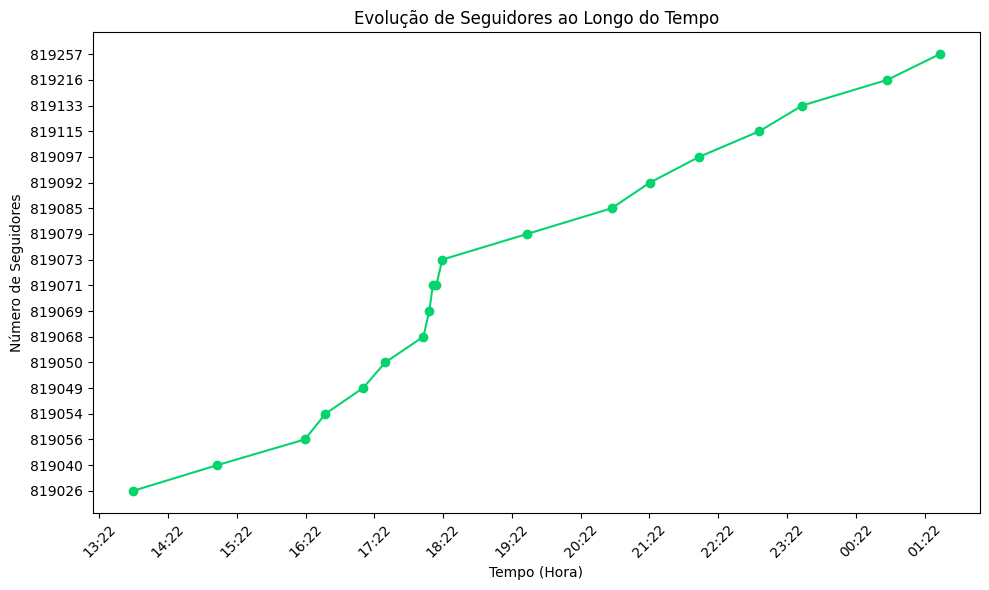

In [643]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Garante que 'ts_exec' seja interpretada como datetime
followers_number_df['ts_exec'] = pd.to_datetime(followers_number_df['ts_exec'])

# Configura o gráfico
plt.figure(figsize=(10, 6))

# Plota os dados de seguidores ao longo do tempo com a cor específica
plt.plot(followers_number_df['ts_exec'],
         followers_number_df['follower_count'].astype(str),
         marker='o',
         linestyle='-',
         color='#05d46e')

# Configurações para melhorar a legibilidade do eixo x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Mostra horas e minutos no eixo x
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=60))  # Marca a cada 60 minutos no eixo x

# Rotaciona os labels do eixo x para não ficarem sobrepostos
plt.xticks(rotation=45)

# Adiciona título e rótulos aos eixos
plt.title('Evolução de Seguidores ao Longo do Tempo')
plt.xlabel('Tempo (Hora)')
plt.ylabel('Número de Seguidores')

# Exibe o gráfico
plt.tight_layout()
plt.show()



Através do gráfico podemos ter uma rápida ideia de que existe um crescimento diário com uma boa acentuação.

Porém precisamos entender qual o crescimento percentual e quantitativo do perfil do nosso influenciador.

Para isso temos de executar o seguinte código:

In [644]:
# Garantir que 'ts_exec' seja do tipo datetime
followers_number_df['ts_exec'] = pd.to_datetime(followers_number_df['ts_exec'])

# Calcular o crescimento total no período (percentual)
total_growth = followers_number_df['growth'].iloc[-1] - followers_number_df['growth'].iloc[0]

# Calcular a diferença total de horas entre o primeiro e o último registro e transformar em horas
total_hours = (followers_number_df['ts_exec'].iloc[-1] - followers_number_df['ts_exec'].iloc[0]).total_seconds() / 3600

# Calcular o crescimento percentual médio por hora e estimar por dia
growth_per_hour = total_growth / total_hours
growth_per_day = growth_per_hour * 24

# Calcular o número de seguidores adicionados por hora e por dia
# O número inicial de seguidores é o follower_count no primeiro registro
initial_followers = followers_number_df['follower_count'].iloc[0]

# Número de seguidores adicionados por hora e por dia
followers_per_hour = initial_followers * growth_per_hour
followers_per_day = followers_per_hour * 24

# Exibindo os resultados
print(f'Crescimento percentual médio por hora: {growth_per_hour*100:.6f} %')
print(f'Crescimento percentual estimado por dia: {growth_per_day*100:.6f} %')
print(f'Número de seguidores adicionados por hora: {round(followers_per_hour)}')
print(f'Número de seguidores adicionados por dia: {round(followers_per_day)}')

Crescimento percentual médio por hora: 0.002406 %
Crescimento percentual estimado por dia: 0.057738 %
Número de seguidores adicionados por hora: 20
Número de seguidores adicionados por dia: 473


Notamos que o crescimento estimado ao dia do perfil é de 0,05 % que equivale à um crescimento absoluto de 473 seguidores.

### Estatísticas de crescimento das Postagens

Para calcular as postagens temos de primeiro obter as informações do Spark. Após isso temos de limpar e ajustar as informações para termos uma métrica mais acertiva.

In [645]:
# Carregar o DataFrame sem .show()
posts_data_df = spark.read.parquet(f'{data_lake_path}{posts_path}').select(
    'code', 'device_timestamp', 'like_count', 'comment_count', 'ts_exec')\
    .orderBy('ts_exec', ascending=True)

# Convertendo device_timestamp para data legível
posts_data_df = posts_data_df.withColumn(
    "device_timestamp", from_unixtime(col("device_timestamp")/1000000, "yyyy-MM-dd HH:mm:ss"))

posts_data_df = posts_data_df.withColumn('ts_exec', date_format(col('ts_exec'), format='yyyy-MM-dd HH:mm:ss'))

posts_data_df = posts_data_df.select('code','device_timestamp', 'like_count', 'comment_count', 'ts_exec').toPandas()

posts_data_df = posts_data_df.dropna()

# Garantir que 'ts_exec' seja do tipo datetime
posts_data_df['ts_exec'] = pd.to_datetime(posts_data_df['ts_exec'])
posts_data_df['device_timestamp'] = pd.to_datetime(posts_data_df['device_timestamp'])
posts_data_df['like_count'] = posts_data_df['like_count'].astype(int)
posts_data_df['comment_count'] = posts_data_df['comment_count'].astype(int)



Tendo o dataframe as informações de postagens podemos enfim calcular para cada postagem as métricas:
\
* Período em horas (`total_hours`);
* Quantidade Total de Likes no período (`total_growth_likes`);
* Quantidade de Likes por hora (`growth_likes_per_hour`);
* Quantidade de Likes estimado por dia (`growth_likes_per_day`);
* Percentual de Likes por hora (`percent_likes_per_hour`);
* Percentual de Likes estimado por dia (`percent_likes_per_day`);

* Quantidade Total de Comentários no período (`total_growth_comments`);
* Quantidade de Comentários por hora (`growth_comments_per_hour`);
* Quantidade de Comentários estimado por dia (`growth_comments_per_day`);
* Percentual de Comentários por hora (`percent_comments_per_hour`);
* Percentual de Comentários estimado por dia (`percent_comments_per_day`).


In [646]:
# Função para calcular o crescimento e estimativas
def calculate_growth_stats(group_data):
    # Remover valores NaN e zeros
    group = group_data.copy()

    group = group.dropna(subset=['like_count', 'comment_count'])
    group = group[group['like_count'] > 0]
    group = group[group['comment_count'] > 0]

    # Passo 1: Calcular o crescimento total no período (percentual)
    total_growth_likes = float(group['like_count'].iloc[-1] - group['like_count'].iloc[0])
    total_growth_comments = float(group['comment_count'].iloc[-1] - group['comment_count'].iloc[0])

    # Passo 2: Calcular a diferença total de horas entre o primeiro e o último registro
    total_hours = float((group['ts_exec'].iloc[-1] - group['ts_exec'].iloc[0]).total_seconds() / 3600)

    if len(group) < 2 or total_hours == 0:
        return pd.Series({
            'total_growth_likes': float('nan'),
            'total_growth_comments': float('nan'),

            'total_hours': float('nan'),

            'growth_likes_per_hour': float('nan'),
            'growth_likes_per_day': float('nan'),

            'percent_likes_per_hour': float('nan'),
            'percent_likes_per_day': float('nan'),

            'percent_comments_per_hour': float('nan'),
            'percent_comments_per_day': float('nan')
        })

    # Passo 3: Calcular o crescimento percentual médio por hora e estimar por dia
    growth_per_hour_likes = total_growth_likes / total_hours
    growth_per_hour_comments = total_growth_comments / total_hours

    growth_per_day_likes = growth_per_hour_likes * 24
    growth_per_day_comments = growth_per_hour_comments * 24


    # Passo 4: Calcular o número de seguidores adicionados por hora e por dia
    initial_likes = group['like_count'].iloc[0]
    initial_comments = group['comment_count'].iloc[0]

    percent_likes_per_hour = growth_per_hour_likes*100/initial_likes
    percent_comments_per_hour = growth_per_hour_comments*100/initial_comments

    percent_likes_per_day = percent_likes_per_hour * 24
    percent_comments_per_day = percent_comments_per_hour * 24

    return pd.Series({
        'total_growth_likes': total_growth_likes,
        'total_growth_comments': total_growth_comments,

        'total_hours': total_hours,

        'growth_likes_per_hour': growth_per_hour_likes,
        'growth_likes_per_day': growth_per_day_likes,

        'percent_likes_per_hour': percent_likes_per_hour,
        'percent_likes_per_day': percent_likes_per_day,

        'percent_comments_per_hour': percent_comments_per_hour,
        'percent_comments_per_day': percent_comments_per_day
    })

# Aplicar a função de cálculo para cada grupo de código
growth_stats = posts_data_df.groupby('code').apply(calculate_growth_stats).reset_index()

growth_stats = growth_stats.dropna()

# # Exibindo os resultados
growth_stats.head(10)

growth_stats.set_index('code', inplace=True)

growth_stats.head(10)

,total_growth_likes,total_growth_comments,total_hours,growth_likes_per_hour,growth_likes_per_day,percent_likes_per_hour,percent_likes_per_day,percent_comments_per_hour,percent_comments_per_day
code,,,,,,,,,
C_15T3IOHlx,510.0,7.0,11.721944,43.508140,1044.195360,0.287562,6.901489,0.148550,3.565197
C_1PBmBBIRd,456.0,2.0,11.721944,38.901396,933.633498,0.248794,5.971051,0.102783,2.466797
C_36o8wOmvw,612.0,5.0,11.721944,52.209768,1253.034432,0.449542,10.789000,0.218744,5.249851
C_3dUhguFbD,21.0,0.0,11.721944,1.791512,42.996280,0.443443,10.642643,0.000000,0.000000
C_4LTB9Oiym,85.0,1.0,11.721944,7.251357,174.032560,0.488965,11.735169,0.181511,4.356259
C_6vWsLOzlD,366.0,15.0,11.721944,31.223489,749.363729,3.109909,74.637822,3.046789,73.122924
C_6xVS9O-6D,528.0,21.0,11.721944,45.043721,1081.049314,3.369014,80.856344,1.756384,42.153215
C_8UqB0O2hO,1199.0,106.0,9.227778,129.933775,3118.410596,29.463441,707.122584,27.350133,656.403199
C_8_MnrBJBH,7341.0,115.0,3.497500,2098.927806,50374.267334,66.128790,1587.090968,43.840839,1052.180129


Ao pegar visualizar as métricas percebemos que existem postagens com crescimentos muito alterados que podem enviesar nossa estimativa, então é importante desconsiderarmos eles antes de prosseguir.
Ao analisarmos esses dados verificamos que além do crescimento incongruente eles também são mais recentes do que o horário comum entre os dados que são aproximadamente 11h.
Nesse sentido se faz justo filtrar apenas os dados que estão dentro do valor 'moda' que são essas 11h.

In [647]:
growth_stats = growth_stats[growth_stats['total_hours'] == growth_stats['total_hours'].mode()[0]]

growth_stats.head(10)

,total_growth_likes,total_growth_comments,total_hours,growth_likes_per_hour,growth_likes_per_day,percent_likes_per_hour,percent_likes_per_day,percent_comments_per_hour,percent_comments_per_day
code,,,,,,,,,
C_15T3IOHlx,510.0,7.0,11.721944,43.508140,1044.195360,0.287562,6.901489,0.148550,3.565197
C_1PBmBBIRd,456.0,2.0,11.721944,38.901396,933.633498,0.248794,5.971051,0.102783,2.466797
C_36o8wOmvw,612.0,5.0,11.721944,52.209768,1253.034432,0.449542,10.789000,0.218744,5.249851
C_3dUhguFbD,21.0,0.0,11.721944,1.791512,42.996280,0.443443,10.642643,0.000000,0.000000
C_4LTB9Oiym,85.0,1.0,11.721944,7.251357,174.032560,0.488965,11.735169,0.181511,4.356259
C_6vWsLOzlD,366.0,15.0,11.721944,31.223489,749.363729,3.109909,74.637822,3.046789,73.122924
C_6xVS9O-6D,528.0,21.0,11.721944,45.043721,1081.049314,3.369014,80.856344,1.756384,42.153215
C_Onz-lu6yr,13.0,0.0,11.721944,1.109031,26.616744,0.040624,0.974972,0.000000,0.000000
C_bL06ZRbed,5.0,0.0,11.721944,0.426550,10.237209,0.074312,1.783486,0.000000,0.000000


Já com os dados ajustados calculamos as médias entre os posts.

In [648]:
growth_stats.mean()

,0
total_growth_likes,261.400000
total_growth_comments,5.100000
total_hours,11.721944
growth_likes_per_hour,22.300055
growth_likes_per_day,535.201308
percent_likes_per_hour,0.864432
percent_likes_per_day,20.746357
percent_comments_per_hour,0.545476
percent_comments_per_day,13.091424


Notamos que houve no período um crescimento médio de 261 curtidas e 5 comentários por postagem.
\
Um aumento de 20% em curtidas e 13% de comentários ao dia.


## Classificação de comentários

#### Desenvolvimento

Primeiro vamos criar o LLM através da função `create_model`.

In [649]:
def create_model():
    """
    Cria e retorna um cliente Groq usando a chave de API.

    Args:
        None. A função utiliza a chave de API armazenada em 'userdata'.

    Returns:
        Groq: Um objeto cliente da API Groq, autenticado com a chave de API.

    Dependências:
        - A chave de API 'GROQ_API_KEY' deve estar disponível em 'userdata'.
    """
    client = Groq(
        api_key=userdata.get("GROQ_API_KEY"),
    )
    return client

model = create_model()


In [ ]:
def classifica_comentario_groq(p_text):
    """
    Classifica o sentimento de um texto usando a API do Groq.
    Args:
      text:
    """
    pergunta = f'Classifique o comentário a seguir em (positivo, negativo, neutro, humor), retorno apenas a classificação (não retorne emojis, somente as opções de classificação que dei): {p_text}'

    print(pergunta)
    response = model.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": pergunta,
            }
        ],
        model="llama3-8b-8192",
    )
    return response.choices[0].message.content

Agora fazer uma verificação para o caso de não haver nenhuma informação dentro ou até mesmo o próprio diretório de classificação de comentários.

In [650]:
# Verifica se existe alguma partição no diretório de comentários classificados, caso não, ele cria o diretório.
if not os.path.exists(f'{data_lake_path}{classified_comments_path}/part-'):
    schema = StructType([
        StructField("pk", StringType(), nullable=True),
        StructField("text_original", StringType(), nullable=True),
        StructField("classificacao", StringType(), nullable=True)
    ])

    print(response_instagram_comments_data)
    array_comments_analise = []

    df = spark.createDataFrame(array_comments_analise, schema=schema)

    df.write.mode("append").format('parquet').save(f'{data_lake_path}{classified_comments_path}')

[('17869495407193767', '2719430372', '', 0, 0, 'jccesinha', 'Julio Cesar', False), ('17870081787123796', '1640503132', '👏👏👏maravilhoso', 0, 0, 'adry.ventura', 'Adriane Ventura', False), ('17857713969200314', '3163842586', 'Com a minha mãe era no olhar, na rua ela se controlava afu kkk dava só aquele olhar fuminante pra nós e dizia baixinho, "em casa tu vai ver" chegava em casa o relho cantava 😂😂😂', 0, 0, 'jessica.l45', 'Jéssica Santos', False), ('18045792727938159', '607010578', '😂😂😂😂😂', 0, 0, 'gabhriel_1984', 'Gabriel Carvalho', False), ('18032713187214272', '9160243756', '🤣🤣🤣🤣', 0, 0, 'silva.sdb', 'André Brida', False), ('17990512850546280', '3278632530', 'Apanhavam de "vara"!?! (Lá ele)', 0, 1, 'vinitirapellesilva', 'Vinicius T da Silva', False), ('17918578961882458', '1173251318', '😂😂', 0, 0, 'julianajl31', 'Juliana Silva', False), ('17933814080919718', '2271092704', '"se correr é pior"', 0, 0, 'arthurhpuhl', 'Arthur Henrique Puhl', False), ('18037055840510884', '66103351095', '😂😂😂

Cruza os comentários com as classificações e monta um array com os comentários que precisam ser classificados

In [651]:
df_comentarios = spark.read.parquet(f'{data_lake_path}{comments_path}')
df_classificacao = spark.read.parquet(f'{data_lake_path}{classified_comments_path}')


df_comentarios_para_classificar = df_comentarios.join(df_classificacao, 'pk', 'left')

df_comentarios_para_classificar.createOrReplaceTempView('comentarios_para_classificar')
df = spark.sql('select pk, text, classificacao from comentarios_para_classificar where classificacao is null')

df = df.drop_duplicates()
lista_linhas = df.rdd.map(lambda row: row.asDict()).collect()

# Imprime quantos comentários faltam ser classificados
print(df.count())

13


Agora iremos chamar a função `classifica_comentario` para cada um dos comentários presentes no dataframe e depois preencher um novo array para usarmos mais tarde.

In [652]:
array_comments_analise = []

for comentario in lista_linhas:
    pk = comentario.get('pk')
    text = comentario.get('text')

    retorno_ai = classifica_comentario_groq(text)
    time.sleep(3) # espera 3s para a nova requisição fazendo no máximo 20 req. por min. Max da API são 30/min
    array_comments_analise.append((pk,text,retorno_ai))


Classifique o comentário a seguir em (positivo, negativo, neutro, humor), retorno apenas a classificação (não retorne emojis, somente as opções de classificação que dei): 👏👏👏maravilhoso
Classifique o comentário a seguir em (positivo, negativo, neutro, humor), retorno apenas a classificação (não retorne emojis, somente as opções de classificação que dei): 😂😂
Classifique o comentário a seguir em (positivo, negativo, neutro, humor), retorno apenas a classificação (não retorne emojis, somente as opções de classificação que dei): Apanhavam de "vara"!?! (Lá ele)
Classifique o comentário a seguir em (positivo, negativo, neutro, humor), retorno apenas a classificação (não retorne emojis, somente as opções de classificação que dei): Com a minha mãe era no olhar, na rua ela se controlava afu kkk dava só aquele olhar fuminante pra nós e dizia baixinho, "em casa tu vai ver" chegava em casa o relho cantava 😂😂😂
Classifique o comentário a seguir em (positivo, negativo, neutro, humor), retorno apenas 

Com o array já preenchido com as classificações vamos salvar as novas atualizações no DataLake

In [653]:
schema = StructType([
        StructField("pk", StringType(), nullable=True),
        StructField("text_original", StringType(), nullable=True),
        StructField("classificacao", StringType(), nullable=True)
])

print(response_instagram_comments_data)

df = spark.createDataFrame(array_comments_analise, schema=schema)
df = df.withColumn('ts_exec', F.current_timestamp())

df.write.mode("append").format('parquet').save(f'{data_lake_path}{classified_comments_path}')

[('17869495407193767', '2719430372', '', 0, 0, 'jccesinha', 'Julio Cesar', False), ('17870081787123796', '1640503132', '👏👏👏maravilhoso', 0, 0, 'adry.ventura', 'Adriane Ventura', False), ('17857713969200314', '3163842586', 'Com a minha mãe era no olhar, na rua ela se controlava afu kkk dava só aquele olhar fuminante pra nós e dizia baixinho, "em casa tu vai ver" chegava em casa o relho cantava 😂😂😂', 0, 0, 'jessica.l45', 'Jéssica Santos', False), ('18045792727938159', '607010578', '😂😂😂😂😂', 0, 0, 'gabhriel_1984', 'Gabriel Carvalho', False), ('18032713187214272', '9160243756', '🤣🤣🤣🤣', 0, 0, 'silva.sdb', 'André Brida', False), ('17990512850546280', '3278632530', 'Apanhavam de "vara"!?! (Lá ele)', 0, 1, 'vinitirapellesilva', 'Vinicius T da Silva', False), ('17918578961882458', '1173251318', '😂😂', 0, 0, 'julianajl31', 'Juliana Silva', False), ('17933814080919718', '2271092704', '"se correr é pior"', 0, 0, 'arthurhpuhl', 'Arthur Henrique Puhl', False), ('18037055840510884', '66103351095', '😂😂😂

Verificamos por fim se algo ficou para trás.

In [654]:
df_comentarios = spark.read.parquet(f'{data_lake_path}{comments_path}')
df_classificacao = spark.read.parquet(f'{data_lake_path}{classified_comments_path}')

df_comentarios_para_classificar = df_comentarios.join(df_classificacao, 'pk', 'left')

df_comentarios_para_classificar.createOrReplaceTempView('comentarios_para_classificar')

spark.sql('select * from comentarios_para_classificar where classificacao is null').show(truncate=False)

+---+-------+----+------------------+-------------------+-------------+--------------+----------------+-------+-------------+-------------+-------+
|pk |user_id|text|comment_like_count|child_comment_count|user_username|user_full_name|user_is_verified|ts_exec|text_original|classificacao|ts_exec|
+---+-------+----+------------------+-------------------+-------------+--------------+----------------+-------+-------------+-------------+-------+
+---+-------+----+------------------+-------------------+-------------+--------------+----------------+-------+-------------+-------------+-------+



## Analise dos comentários do Último Post

Tendo agora as informações de comentários atualizados e classificados vamos analisá-los para saber qual o sentimento dos seguidores.
\
Para isso iremos extrair do nosso DataLake as informações de comentários classificados para um dataframe Pandas.
\
Após isso iremos desprezar quais dados mal classificados para não comprometer nossas métricas.

In [623]:
df_comentarios_classificados = spark.sql('select * from comentarios_para_classificar')

df_comentarios_classificados.createOrReplaceTempView('comentarios_para_classificar')

classificacoes = spark.sql('select pk, classificacao from comentarios_para_classificar').toPandas()

classificacoes['classificacao'] = classificacoes['classificacao'].apply(lambda x: x.lower())

classificacoes = classificacoes[classificacoes['classificacao'].isin(['humor', 'positivo', 'negativo', 'neutro'])]


Tendo nossos dados já ajustados iremos criar um gráfico de barras para visualizar essas informações.

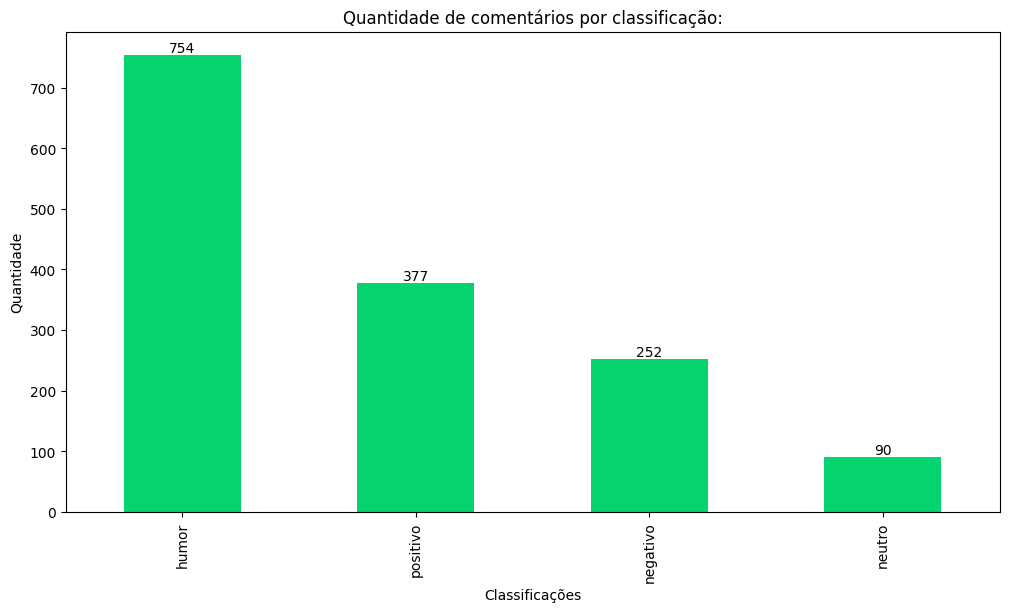

In [626]:
# Cria a figura e o gráfico de barras com cor personalizada
plt.figure(figsize=(10, 6))
ax = classificacoes['classificacao'].value_counts().plot(kind='bar', color='#05d46e')

# Adiciona os valores exatos sobre cada barra
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10)

# Mostra o gráfico
plt.tight_layout()
plt.xlabel('Classificações')
plt.ylabel('Quantidade')
plt.title('Quantidade de comentários por classificação:')
plt.show()


Percebemos que de fato o público costuma a reagir com humor e de maneira positiva às postagens do influenciador, indicando uma boa aceitação do público ao nosso influênciador.

# Tópicos à melhorar

1 - Para evitar a perda de dados no Google Colab é uma boa alternativa utilizar o Google Drive como hospedagem do nosso Data Lake.

Segue exemplo de código:

```python
from google.colab import drive
drive.mount('/content/drive')

drive_path = '/content/drive/My Drive/Datalake/Instagram/'
profile_path = 'Perfil_v2/'
posts_path = 'Postagens_v2/'
comments_path = 'comentarios/'
classified_comments_path = 'comentarios_classificacao/'

df.write.mode("append").format('parquet').save(f'{data_lake_path}{profile_path}')
df.write.mode("append").format('parquet').save(f'{data_lake_path}{posts_path}')
df.write.mode("append").format('parquet').save(f'{data_lake_path}{comments_path}')
df.write.mode("append").format('parquet').save(f'{data_lake_path}{classified_comments_path}')
```